### Experiment 2: Comparing 1D CNN and BiLSTM models using TF-IDF Vectorizer

The primary objective is to compare and contrast the effectiveness of 1D CNN and BiLSTM models in processing TF-IDF transformed text data. 

In [ ]:
# Installing essential Python libraries for data manipulation
!pip install pandas numpy scikit-learn gensim nltk tensorflow

In [ ]:
%pip install datasets
%pip install transformers
%pip install spacy
%pip install torch
%pip install tensorflow
%pip install spacy-transformers
%pip install transformers[torch]
%pip install seqeval
!pip install wordcloud

### Importing Libraries:

We have to import specific python libraries that provide necessary functions and tools for handling the data and performing analyses.

In [ ]:
# For data manipulation
import pandas as pd
# For numerical operations
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
# For splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split
# For classification tasks
from sklearn.svm import SVC
# For accessing the performance metrics
from sklearn.metrics import classification_report
# For working with text
import nltk
# for filtering commonly used words
from nltk.corpus import stopwords
# For stemming words
from nltk.stem import PorterStemmer
# For splitting texts into tokens
from nltk.tokenize import word_tokenize

### Loading Dataset:

I have chosen to use Hugging Face Datasets' "surrey-nlp/PLOD-CW" dataset for this investigation which is available in Surrey learn.

In [9]:
# For loading "surrey-nlp/PLOD-CW" dataset from Hugging Face.
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

# Convert the 'train' split of the PLOD-CW dataset to a Pandas DataFrame for easier manipulation and analysis.
df = dataset['train'].to_pandas()

### Data Information:

After loading the dataset, we are getting an overview of the data using `head()` function.

Featues breakdown:

- **Tokens** - These are discrete words or symbols that were taken out of the dataset texts.
- **Part-of-speech tags (POS_tags)** - These are the grammatical information that are allocated to each token.
- **Named entity recognition tags (NER_tags)** - These tags group names, locations, organisations, and other attributes into predetermined categories for token classification.

In [10]:
# For displaying the first few rows of the DataFrame to preview its structure and the types of data it contains.
df.head()

,tokens,pos_tags,ner_tags
0,"[For, this, purpose, the, Gothenburg, Young, P...","[ADP, DET, NOUN, DET, PROPN, PROPN, PROPN, PRO...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I..."
1,"[The, following, physiological, traits, were, ...","[DET, ADJ, ADJ, NOUN, AUX, VERB, PUNCT, ADJ, N...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF..."
2,"[Minor, H, antigen, alloimmune, responses, rea...","[ADJ, PROPN, NOUN, ADJ, NOUN, ADV, VERB, ADP, ...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,..."
3,"[EPI, =, Echo, planar, imaging, .]","[PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]"
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[ADV, PUNCT, PROPN, PUNCT, VERB, PROPN, NOUN, ...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O..."


In [11]:
# Count missing values in each column
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
tokens      0
pos_tags    0
ner_tags    0
dtype: int64


### Data Preparation:

- **Preparing Text Data:**
The text data from the loaded dataset is prepared by concatenating the tokens for each sample into a single string, using list comprehensions and the join function.
- **TF-IDF Vectorization:**
The TfidfVectorizer is used to convert the text data into TF-IDF vectors. The fit_transform method is called on the training data to fit the vectorizer and transform the training texts, while the transform method is used on the test data to transform it based on the vectorizer fitted with the training data.
- **Encoding Labels:**
The labels from the dataset's NER tags are encoded using LabelEncoder. This step assigns a unique integer to each class in the labels, making it suitable for model training.
- **Converting Labels to One-Hot Encoding:**
The encoded labels are then converted into one-hot encoded format using the to_categorical function. This is necessary for multi-class classification tasks as it represents each class as a binary vector.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Bidirectional, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume dataset['train']['tokens'] and dataset['test']['tokens'] are available
train_texts = [" ".join(tokens) for tokens in dataset['train']['tokens']]
test_texts = [" ".join(tokens) for tokens in dataset['test']['tokens']]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_texts).toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform([tags[1] for tags in dataset['train']['ner_tags']])
y_test = label_encoder.transform([tags[1] for tags in dataset['test']['ner_tags']])

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_encoded = to_categorical(y_test, num_classes=len(label_encoder.classes_))

### Defining models and Performance Comparisom:

- **Building and Training 1D CNN Model:**
A sequential model (model_cnn) is created with a convolutional layer (Conv1D), global max pooling layer (GlobalMaxPooling1D), and a dense layer with softmax activation for multi-class classification.
The model is compiled with the Adam optimizer and categorical crossentropy loss function.
The model is trained (history_cnn) on the TF-IDF transformed training data for 10 epochs with a validation split of 20% and a batch size of 32.
- **Making Predictions with 1D CNN Model:**
Predictions (y_pred_cnn) are made on the TF-IDF transformed test data using the trained 1D CNN model.
- **Building and Training BiLSTM Model:**
Another sequential model (model_bilstm) is created with a bidirectional LSTM layer (Bidirectional), global max pooling layer, and dense layer with softmax activation.
Similar to the 1D CNN model, the BiLSTM model is compiled and trained (history_bilstm) on the TF-IDF transformed training data for 10 epochs with validation split and batch size.
- **Making Predictions with BiLSTM Model:**
Predictions (y_pred_bilstm) are made on the TF-IDF transformed test data using the trained BiLSTM model.
- **Printing Classification Reports:**
Classification reports are printed for both models, showing precision, recall, and F1-score for each class in the test data.
These reports provide insights into the models' performance on different classes and overall accuracy.
- **Visualizing Confusion Matrices:**
Confusion matrices are plotted for both models, providing a visual representation of the models' predictions compared to the actual labels.
The heatmaps in the confusion matrices help in understanding where the models are making correct predictions and where they are getting confused.

In [5]:
model_cnn = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(len(label_encoder.classes_), activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn = model_cnn.fit(np.expand_dims(X_train_tfidf, -1), y_train_encoded, epochs=10, validation_split=0.2, batch_size=32)
y_pred_cnn = np.argmax(model_cnn.predict(np.expand_dims(X_test_tfidf, -1)), axis=1)

/Users/wilson/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8841 - loss: 1.2593 - val_accuracy: 0.8651 - val_loss: 0.9887
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8975 - loss: 0.8836 - val_accuracy: 0.8651 - val_loss: 0.7045
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9102 - loss: 0.5808 - val_accuracy: 0.8651 - val_loss: 0.5658
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8963 - loss: 0.4755 - val_accuracy: 0.8651 - val_loss: 0.5414
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9148 - loss: 0.3998 - val_accuracy: 0.8651 - val_loss: 0.5403
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9188 - loss: 0.3737 - val_accuracy: 0.8651 - val_loss: 0.5381
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9191 - loss: 0.3760 - val_accuracy: 0.8651 - val_loss: 0.5342
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9226 - loss: 0.3606 - val_accuracy: 0.8651 

In [6]:
model_bilstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_tfidf.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(len(label_encoder.classes_), activation='softmax')
])
model_bilstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_bilstm = model_bilstm.fit(np.expand_dims(X_train_tfidf, -1), y_train_encoded, epochs=10, validation_split=0.2, batch_size=32)
y_pred_bilstm = np.argmax(model_bilstm.predict(np.expand_dims(X_test_tfidf, -1)), axis=1)

Epoch 1/10


/Users/wilson/anaconda3/envs/NLP/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9061 - loss: 1.1922 - val_accuracy: 0.8651 - val_loss: 0.6068
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8975 - loss: 0.4605 - val_accuracy: 0.8651 - val_loss: 0.5267
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9057 - loss: 0.4217 - val_accuracy: 0.8651 - val_loss: 0.5278
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8978 - loss: 0.4362 - val_accuracy: 0.8651 - val_loss: 0.5281
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9059 - loss: 0.4181 - val_accuracy: 0.8651 - val_loss: 0.5294
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9088 - loss: 0.3982 - val_accuracy: 0.8651 - val_loss: 0.5285
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8955 - loss: 0.4454 - val_accuracy: 0.8651 - val_loss: 0.5347
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9003 - loss: 0.4231 - val_accuracy: 0.8651 - val_loss: 0.5254
Epo

1D CNN Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         7
           2       0.88      1.00      0.93       134
           3       0.00      0.00      0.00         9

    accuracy                           0.88       153
   macro avg       0.22      0.25      0.23       153
weighted avg       0.77      0.88      0.82       153



/Users/wilson/anaconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wilson/anaconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wilson/anaconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

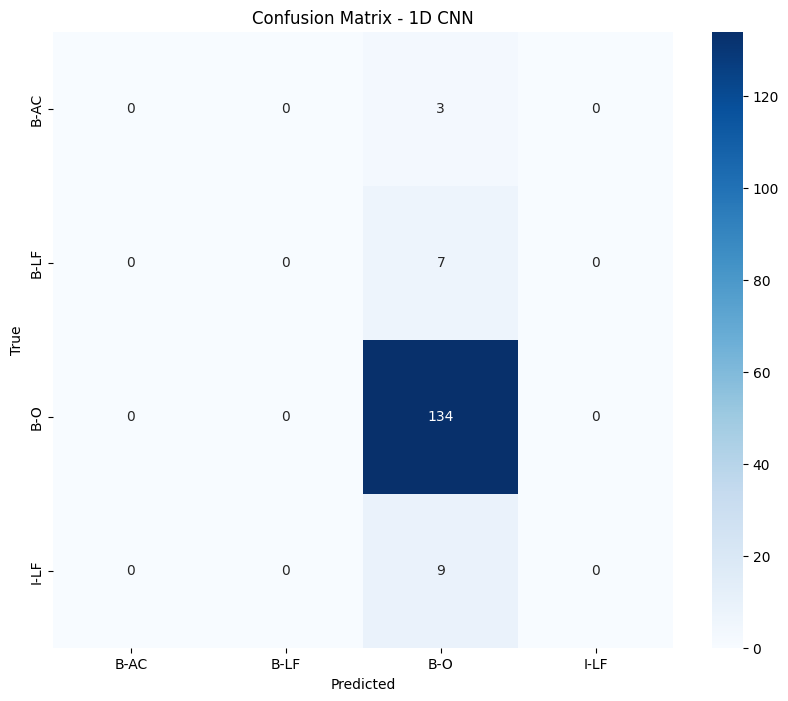

BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         7
           2       0.88      1.00      0.93       134
           3       0.00      0.00      0.00         9

    accuracy                           0.88       153
   macro avg       0.22      0.25      0.23       153
weighted avg       0.77      0.88      0.82       153



/Users/wilson/anaconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wilson/anaconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wilson/anaconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

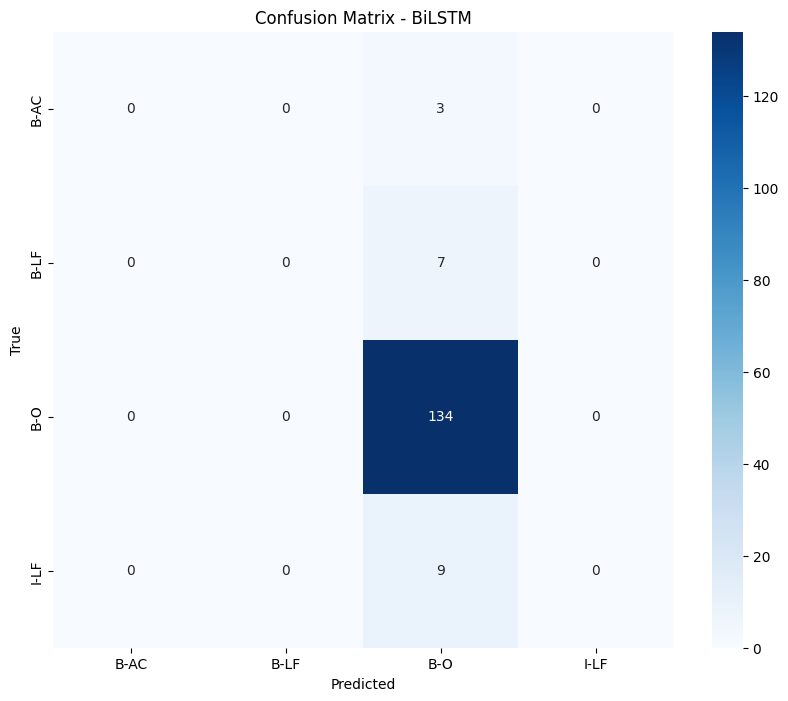

In [7]:
print("1D CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn))
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - 1D CNN')
plt.show()

print("BiLSTM Classification Report:")
print(classification_report(y_test, y_pred_bilstm))
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BiLSTM')
plt.show()

### Conclusion:

Both the 1D CNN and BiLSTM models demonstrate similar performance metrics across precision, recall, and F1-score, as observed in the classification reports. Here's a summarized conclusion based on the provided reports:

- **Precision, Recall, and F1-score:**
For class 2, both models achieved high precision, recall, and F1-score, indicating strong performance in identifying this class.
However, for classes 0, 1, and 3, both models exhibited poor performance with precision, recall, and F1-score being close to zero. This suggests that the models struggled to correctly classify instances of these classes.
- **Overall Accuracy:**
The overall accuracy of both models is 88%, which is misleading as it is largely driven by the correct classification of the dominant class (class 2). The models failed to generalize well across all classes.
- **Model Limitations:**
Both models struggled to distinguish between minority classes, leading to poor performance metrics for those classes.
The models' inability to effectively learn from and classify instances of classes 0, 1, and 3 indicates the need for further investigation into feature representation and model architecture.